In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from sklearn.base import BaseEstimator

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import optuna
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

from tqdm import tqdm

plt.style.use('seaborn-v0_8-whitegrid')

https://data.world/nrippner/ols-regression-challenge

In [2]:
df = pd.read_csv('cancer_reg.csv', encoding="ISO-8859-1")
df

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


# Drop NaN values and outliers, fix non-linearities, dummy the categorical features

In [3]:
# drop NaN
df.dropna(axis=1, inplace=True)
# categorical to dummies
df = pd.get_dummies(df, columns=['binnedInc'], dtype=int)
# drop county names
df.drop(columns=['Geography'], inplace=True)
# drop obvious outliers
df = df[df['MedianAge'] < 200]
df = df[df['incidenceRate'] < 1000]
df = df[df['AvgHouseholdSize'] > 0.05]
df

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,"binnedInc_(34218.1, 37413.8]","binnedInc_(37413.8, 40362.7]","binnedInc_(40362.7, 42724.4]","binnedInc_(42724.4, 45201]","binnedInc_(45201, 48021.6]","binnedInc_(48021.6, 51046.4]","binnedInc_(51046.4, 54545.6]","binnedInc_(54545.6, 61494.5]","binnedInc_(61494.5, 125635]","binnedInc_[22640, 34218.1]"
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,39.3,36.9,...,0,0,0,0,0,0,0,0,1,0
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,33.0,32.2,...,0,0,0,0,0,1,0,0,0,0
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,45.0,44.0,...,0,0,0,0,0,1,0,0,0,0
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,42.8,42.2,...,0,0,0,1,0,0,0,0,0,0
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,48.3,47.8,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,44.2,41.1,...,0,0,0,0,1,0,0,0,0,0
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,30.4,29.3,...,0,0,0,0,0,1,0,0,0,0
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,30.9,30.5,...,0,0,0,0,0,0,1,0,0,0
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,39.0,36.9,...,0,0,0,0,0,1,0,0,0,0


In [4]:
X = df.drop(columns=['TARGET_deathRate']).copy()
y = df['TARGET_deathRate'].copy()

# do not use medical features
X.drop(columns=['incidenceRate'], inplace=True)

# only use relative death rates
X['avgDeathsPerCapita'] = X['avgDeathsPerYear'] / X['popEst2015']
X.drop(columns=['avgDeathsPerYear', 'popEst2015'], inplace=True)

# only use male/female differential median age
X['MedianAgeMaleDiff'] = X['MedianAgeMale'] - X['MedianAge']
X['MedianAgeFemaleDiff'] = X['MedianAgeFemale'] - X['MedianAge']
X.drop(columns=['MedianAgeMale', 'MedianAgeFemale'], inplace=True)

if True:
    # fix skew
    log_columns = [
        'avgAnnCount',
        # 'avgDeathsPerYear',
        # 'popEst2015',
        'studyPerCap',
        'PctBlack',
        'PctAsian',
        'PctOtherRace',
        'PctBachDeg18_24',
        'PctBachDeg25_Over',
    ]
    for c in log_columns:
        X[c + '_log'] = np.log1p(X[c])
    X.drop(columns=log_columns, inplace=True)

    # fix skew
    pow3_columns = ['PctWhite']
    for c in pow3_columns:
        X[c + '_pow3'] = np.power(X[c], 3)
    X.drop(columns=pow3_columns, inplace=True)

# remove any remaining fragmentation
X = X.copy()

# Examine the data after transformations

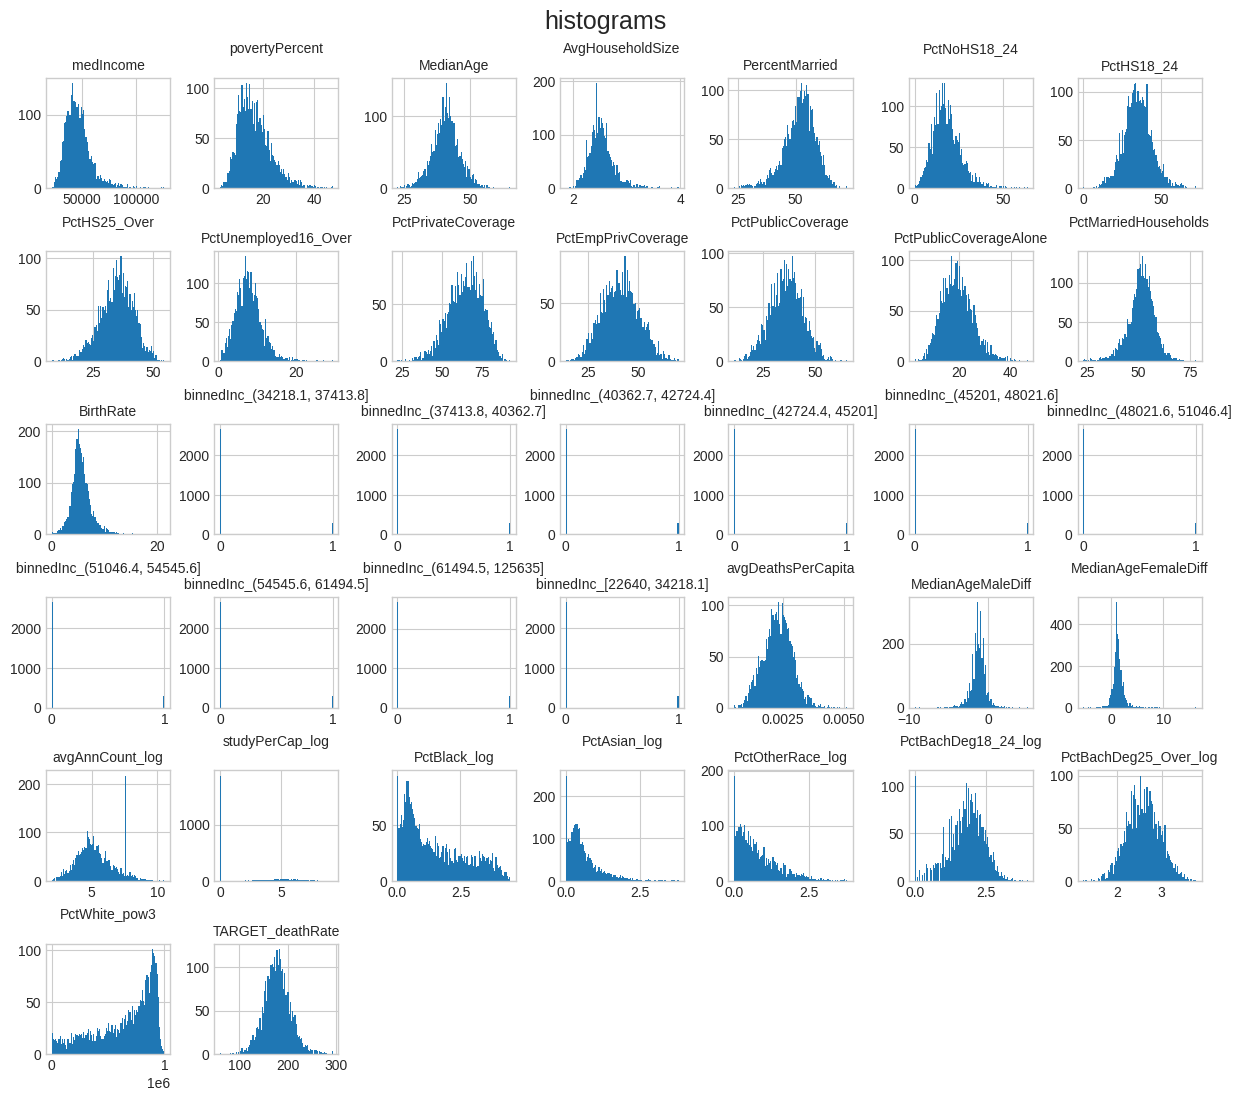

In [5]:
# _ = pd.plotting.scatter_matrix(df, figsize=(20, 20))

fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.suptitle('histograms', fontsize=18)
for i, item in enumerate(pd.concat([X, y], axis=1), 1):
    ax = plt.subplot(7, 7, i)
    ax.hist(pd.concat([X, y], axis=1)[item], bins=100)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

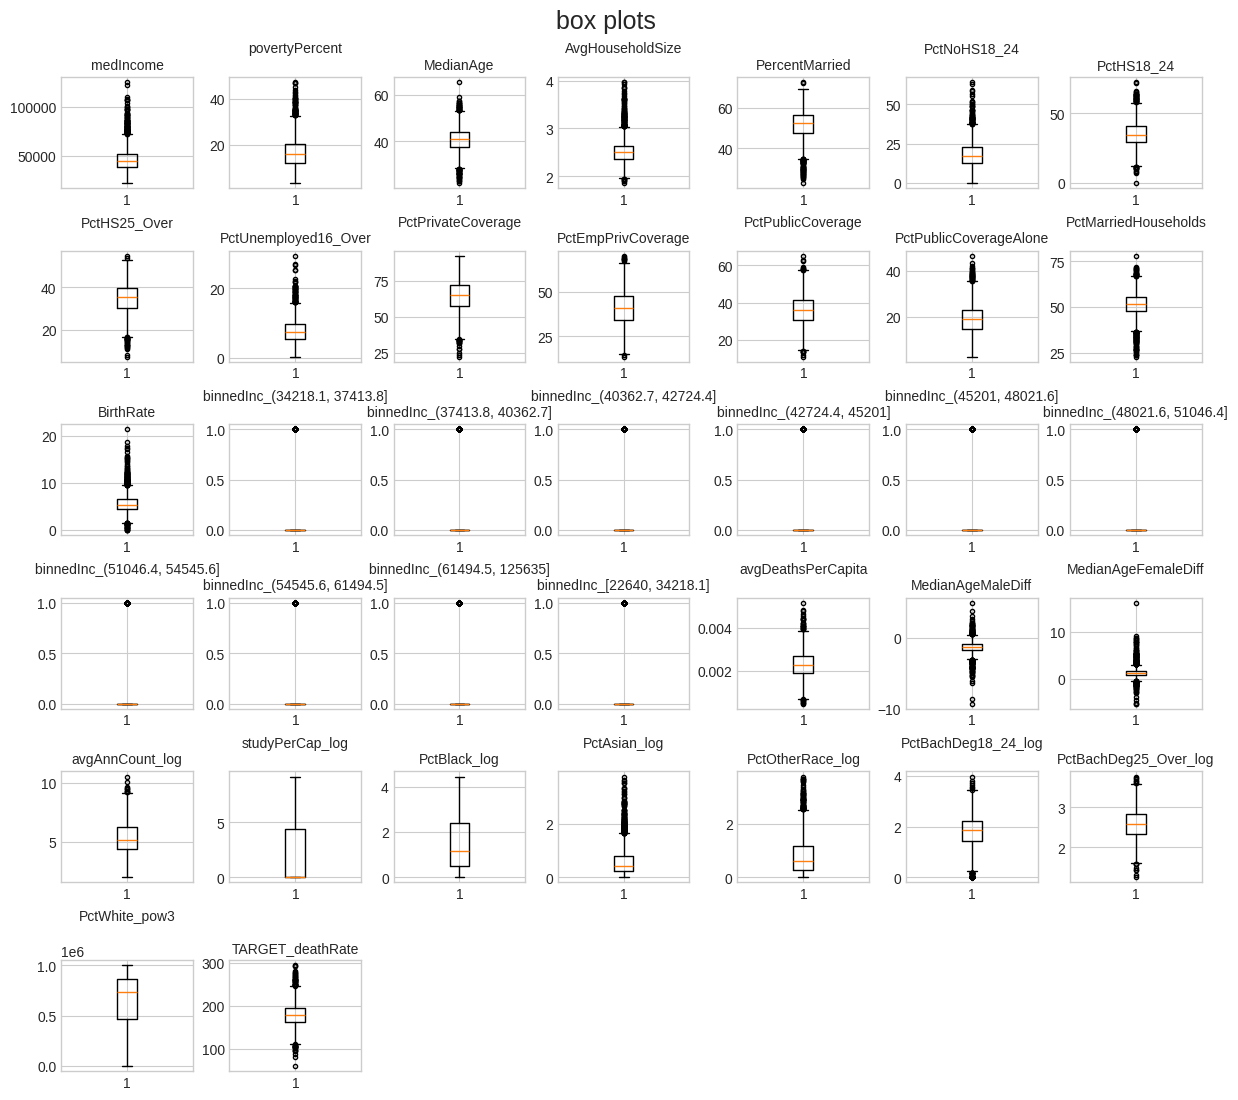

In [6]:
# _ = pd.plotting.scatter_matrix(df, figsize=(20, 20))

fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.suptitle('box plots', fontsize=18)
for i, item in enumerate(pd.concat([X, y], axis=1).columns.to_list(), 1):
    ax = plt.subplot(7, 7, i)
    ax.boxplot(pd.concat([X, y], axis=1)[item], sym='.')
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

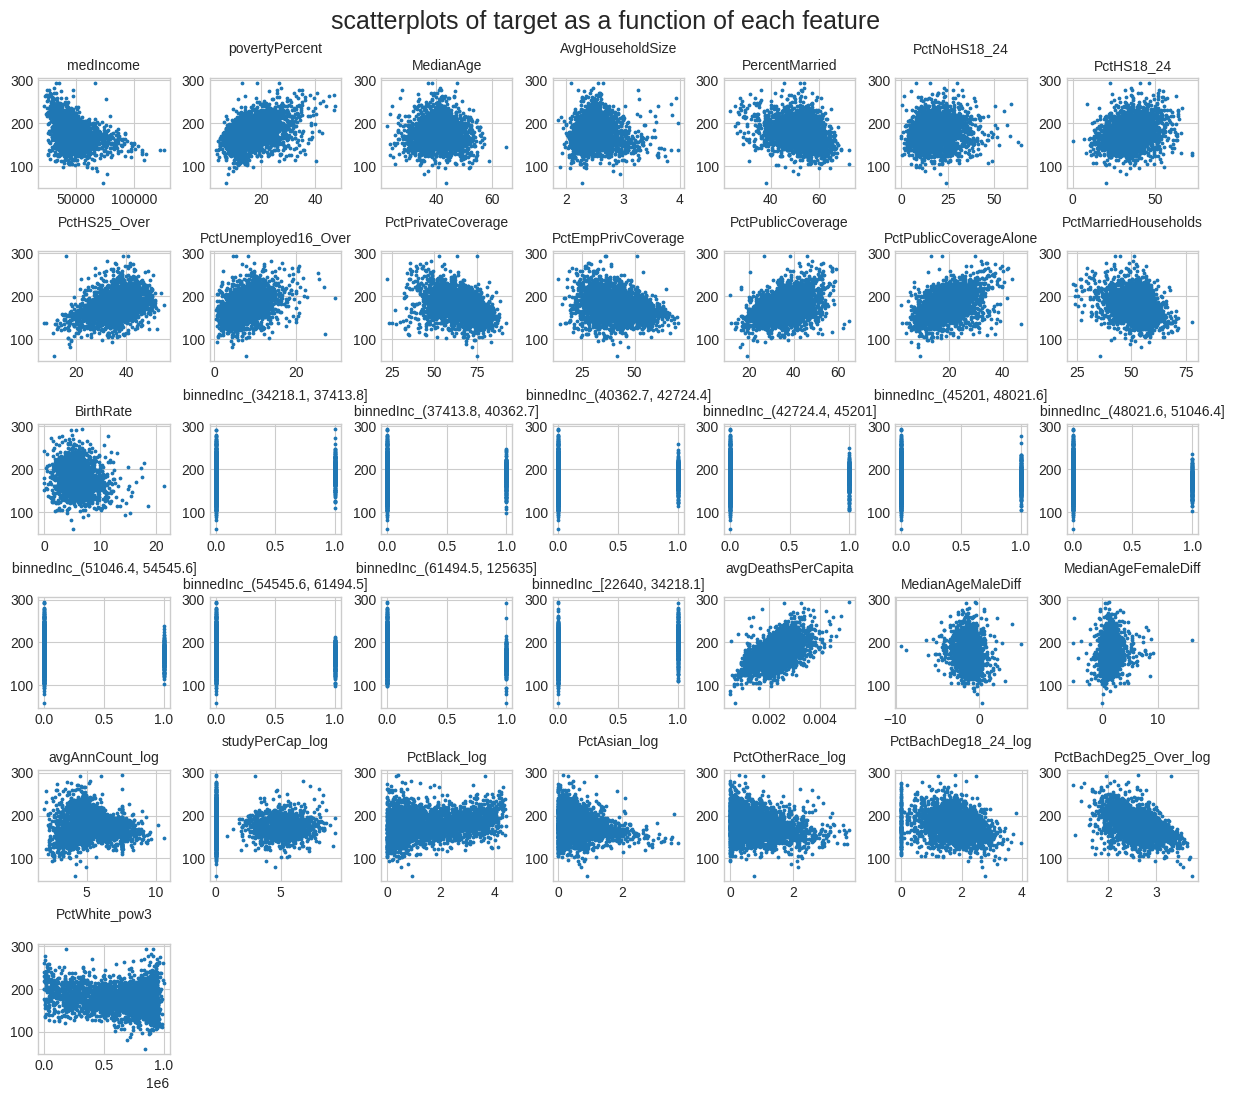

In [7]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.suptitle('scatterplots of target as a function of each feature', fontsize=18)
for i, item in enumerate(X.columns, 1):
    ax = plt.subplot(7, 7, i)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
    plt.scatter(X[item], y, s=3)
plt.show()

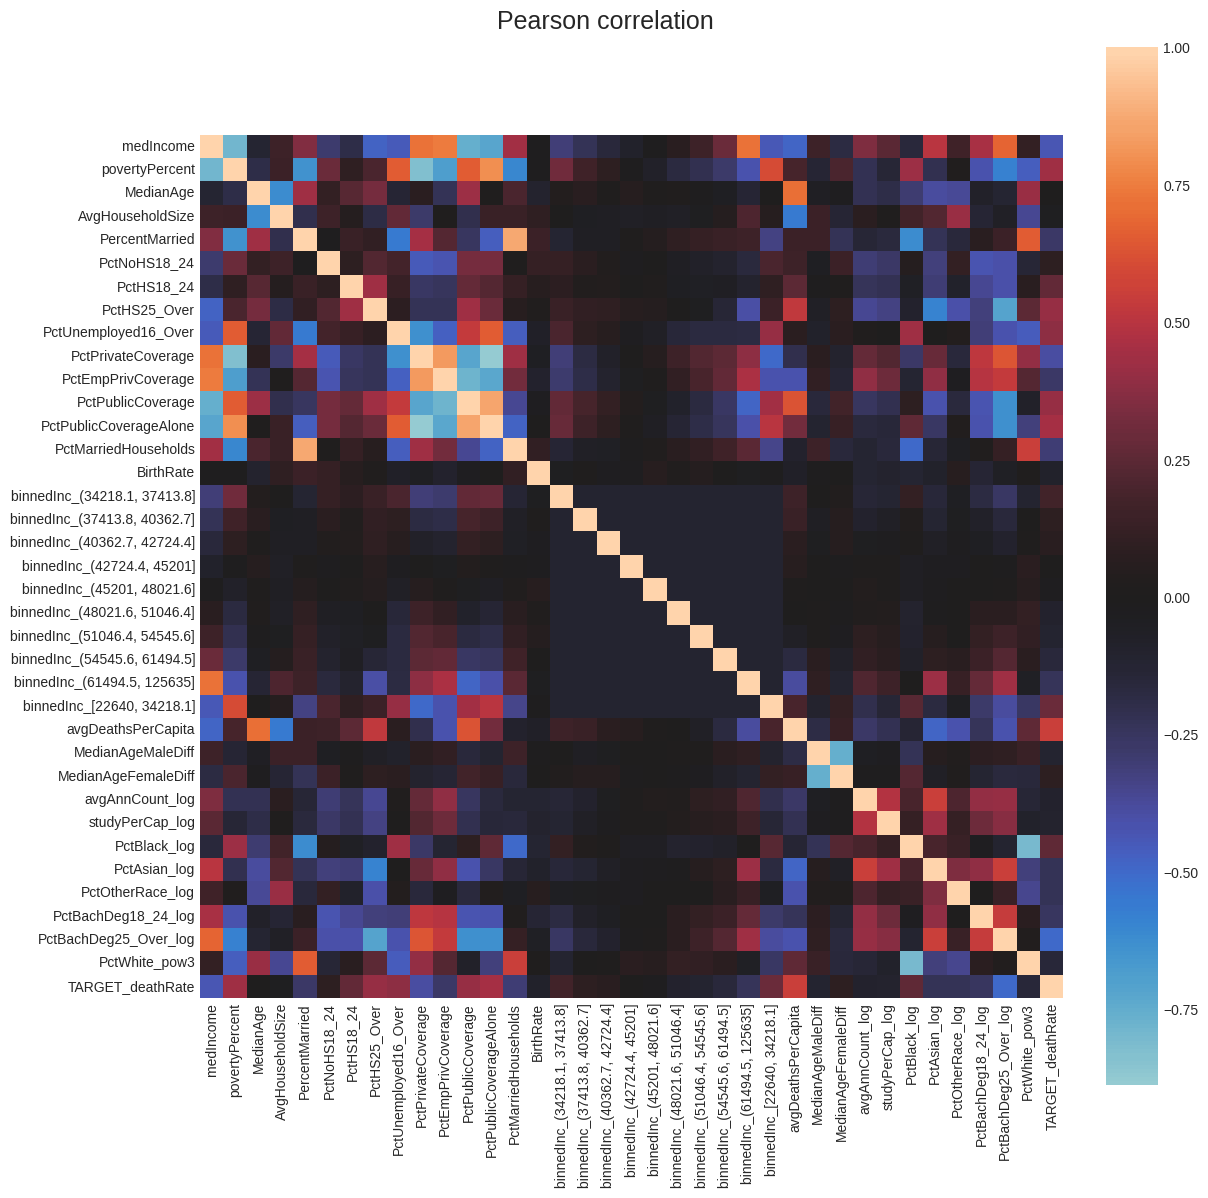

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), layout="constrained")
ax = sns.heatmap(pd.concat([X, y], axis=1).corr(method='pearson'), center=0.0, cmap='icefire', cbar=True, square=True)
fig.suptitle('Pearson correlation', fontsize=18)
fig.show()

# Fit linear model

## Initial fit

In [9]:
X = add_constant(X)

In [10]:
linear_model = sm.OLS(y, X).fit()
print(linear_model.summary2())

                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.773     
Dependent Variable:        TARGET_deathRate       AIC:                      23622.3755
Date:                      2023-12-28 12:59       BIC:                      23838.0484
No. Observations:          2954                   Log-Likelihood:           -11775.   
Df Model:                  35                     F-statistic:              287.7     
Df Residuals:              2918                   Prob (F-statistic):       0.00      
R-squared:                 0.775                  Scale:                    171.87    
--------------------------------------------------------------------------------------
                               Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------------
const                          214.8332  11.9635  17.9574 0.0000   191.

# Feature selection

## Forward search

In [11]:
class DummyEstimator(BaseEstimator):
    # mlxtend wants to use an sklearn estimator, which is not needed here
    # (statsmodels OLS is used instead)
    # create a dummy estimator to pacify mlxtend
    def fit(self, X, y=None, **kwargs):
        return self


def neg_aic(m, X, y):
    # return -AIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.aic


def neg_bic(m, X, y):
    # return -BIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.bic


seq_selector = SFS(
    DummyEstimator(),
    k_features=(1, X.shape[1]),
    forward=True,
    floating=False,
    # BIC creates a more parsimonious model
    # which needs no further tweaks
    # (good VIF, good p-values)
    scoring=neg_bic,
    cv=None,
    n_jobs=-1,
    verbose=0,
    # make sure the intercept is not dropped
    fixed_features=['const'],
)

ex_search = EFS(
    DummyEstimator(),
    min_features=1,
    max_features=X.shape[1],
    print_progress=True,
    scoring=neg_bic,
    cv=None,
    n_jobs=-1,
    fixed_features=['const'],
)

In [12]:
# ex_search_res = ex_search.fit(X.copy(), y.copy())
# ex_search_metrics = ex_search_res.get_metric_dict()

In [13]:
# mlxtend will mess with your dataframes if you don't .copy()
seq_res = seq_selector.fit(X.copy(), y.copy())
seq_metrics = seq_res.get_metric_dict()

/home/florin/.local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/florin/.local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
best_score = -np.inf
r2_of_best_k = 0
r2_list = []
best_k = 1
bfi = []

# also extract R2 from the feature selection search
for k in tqdm(seq_metrics.keys()):
    r2_eval_mod = sm.OLS(y, X[list(seq_metrics[k]['feature_names'])], hasconst=True)
    r2_eval_mod_res = r2_eval_mod.fit()
    r2 = r2_eval_mod_res.rsquared
    r2_list.append(r2)
    score_k = seq_metrics[k]['avg_score']
    if score_k > best_score:
        best_score = score_k
        best_k = k
        bfi = list(seq_metrics[k]['feature_names'])
        r2_of_best_k = r2

print(f'best k:        {best_k}')
print(f'best IC:    {-best_score}')
print(f'r2 @ best k:   {r2_of_best_k}')
print(f'best features: {bfi}')

100%|██████████| 37/37 [00:00<00:00, 570.58it/s]

best k:        16
best IC:    23734.02648603721
r2 @ best k:   0.7710169060079634
best features: ['const', 'medIncome', 'MedianAge', 'PctHS18_24', 'PctUnemployed16_Over', 'PctPrivateCoverage', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctPublicCoverageAlone', 'BirthRate', 'avgDeathsPerCapita', 'MedianAgeMaleDiff', 'MedianAgeFemaleDiff', 'PctBlack_log', 'PctOtherRace_log', 'PctBachDeg25_Over_log']


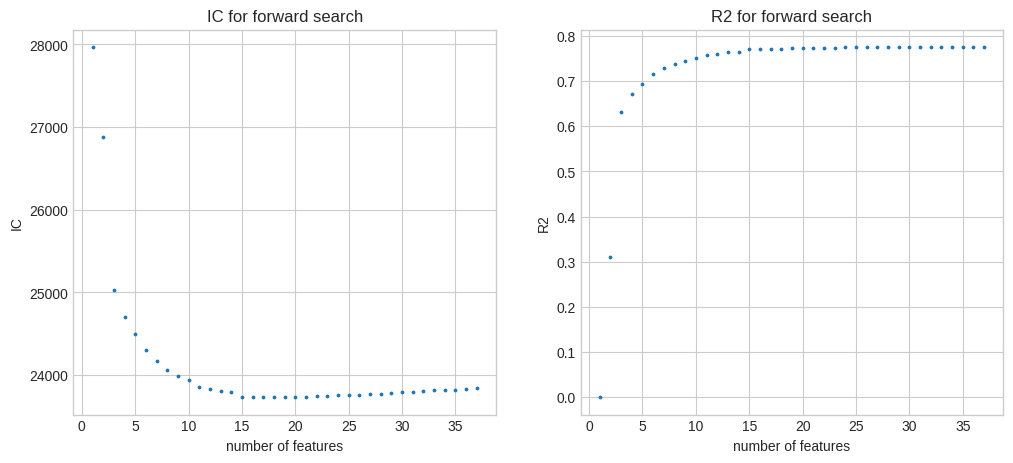

In [15]:
sfs_avg = [-seq_metrics[k]['avg_score'] for k in sorted(seq_metrics.keys())]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(sorted(seq_metrics.keys()), sfs_avg, s=3)
ax[0].set_xticks(sorted(seq_metrics.keys()), minor=True)
ax[0].set_title('IC for forward search')
ax[0].set_xlabel('number of features')
ax[0].set_ylabel('IC')
ax[1].scatter(sorted(seq_metrics.keys()), r2_list, s=3)
ax[1].set_title('R2 for forward search')
ax[1].set_xlabel('number of features')
ax[1].set_ylabel('R2')
fig.show()

In [16]:
X_seq = X[list(seq_metrics[best_k]['feature_names'])].copy()

linear_model_seq = sm.OLS(y, X_seq, hasconst=True).fit()
print(linear_model_seq.summary2())

                        Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.770     
Dependent Variable:      TARGET_deathRate     AIC:                    23638.1718
Date:                    2023-12-28 12:59     BIC:                    23734.0265
No. Observations:        2954                 Log-Likelihood:         -11803.   
Df Model:                15                   F-statistic:            659.5     
Df Residuals:            2938                 Prob (F-statistic):     0.00      
R-squared:               0.771                Scale:                  173.96    
--------------------------------------------------------------------------------
                         Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------
const                    203.4529   6.2999  32.2946 0.0000   191.1002   215.8056
medIncome                  0.0004   0.0000   9.2308 0

In [17]:
def compute_vifs(df, drop_columns=['const']):
    df = df.copy()
    vif_list = []
    vif_names = []

    for i, cname in enumerate([c for c in df.columns.to_list() if c not in drop_columns]):
        try:
            vif = variance_inflation_factor(df, i)
        except Exception as e:
            vif = pd.NA
        vif_list.append(vif)
        vif_names.append(cname)

    vif_df = pd.DataFrame(vif_list, index=vif_names, columns=['vif'])
    vif_df.sort_values(by='vif', ascending=False, inplace=True)
    return vif_df


vif_lin = compute_vifs(X_seq)
vif_lin

,vif
medIncome,673.962236
PctPublicCoverageAlone,23.138364
BirthRate,21.973267
PctEmpPrivCoverage,13.465270
PctPublicCoverage,6.761053
PctHS18_24,4.698071
MedianAge,4.240108
MedianAgeMaleDiff,3.502074
PctBlack_log,2.629011
MedianAgeFemaleDiff,2.533523


# Feature selection with Optuna

In [18]:
def bic(m, X, y):
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return lin_mod_res.bic


def fs_objective(trial, X, y, features):
    # features_use = ['const'] + [f for f in random.sample(features, k=len(features)) if trial.suggest_int(f, 0, 1) == 1]
    features_use = ['const'] + [f for f in random.sample(features, k=len(features)) if trial.suggest_categorical(f, [0, 1]) == 1]
    return bic(None, X[features_use], y)


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
                frozen_trial.number,
                frozen_trial.value,
                frozen_trial.params,
            )
        )


def optuna_create_study(storage, fs_sampler, study_name, direction, load_if_exists):
    return optuna.create_study(
        storage=storage, sampler=fs_sampler, study_name=study_name, direction=direction, load_if_exists=load_if_exists
    )


def optimize_study(
    storage,
    fs_sampler,
    study_name,
    direction,
    load_if_exists,
    fs_objective,
    X,
    y,
    features_select,
    n_trials,
    timeout,
    logging_callback,
    show_progress_bar,
):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna_create_study(storage, fs_sampler, study_name, direction, load_if_exists)
    study.optimize(
        lambda trial: fs_objective(trial, X.copy(), y.copy(), features_select),
        n_trials=n_trials,
        timeout=timeout,
        n_jobs=1,
        callbacks=[logging_callback],
        show_progress_bar=show_progress_bar,
    )


# fs_sampler = optuna.samplers.TPESampler(consider_endpoints=True, n_startup_trials=10, seed=0, constant_liar=True)
# fs_sampler = optuna.samplers.CmaEsSampler(seed=0, n_startup_trials=1, with_margin=True)
# fs_sampler = optuna.samplers.QMCSampler(qmc_type='sobol', scramble=True, seed=0)
# fs_sampler = optuna.samplers.NSGAIISampler(seed=0)
fs_sampler = optuna.samplers.NSGAIIISampler(seed=0)

features_select = [f for f in X.columns if f != 'const']

# strongly suggest you use MySQL storage here
study_storage = os.environ['OPTUNA_URL']
study_name = 'feature_selection'
study_direction = 'minimize'

STUDY_RESET = False
if STUDY_RESET:
    # delete existing study, start from scratch
    optuna.delete_study(study_name=study_name, storage=study_storage)

# create study if not exists
study_total = optuna_create_study(
    storage=study_storage, fs_sampler=fs_sampler, study_name=study_name, direction=study_direction, load_if_exists=True
)

/tmp/ipykernel_7954/1192155253.py:62: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  fs_sampler = optuna.samplers.NSGAIIISampler(seed=0)
[I 2023-12-28 12:59:44,561] A new study created in RDB with name: feature_selection


In [19]:
if False:
    print('Pre-queue trials in the study:')
    print()

    print('null model (intercept only)')
    trial_params = {k: 0 for k in features_select}
    study_total.enqueue_trial(params=trial_params, skip_if_exists=True)

    print('full model (all features)')
    trial_params = {k: 1 for k in features_select}
    study_total.enqueue_trial(params=trial_params, skip_if_exists=True)

    print('only one feature enabled, the rest disabled')
    for i in tqdm(features_select):
        trial_params = {k: (1 if k == i else 0) for k in features_select}
        study_total.enqueue_trial(params=trial_params, skip_if_exists=True)

    print('only one feature disabled, the rest enabled')
    for i in tqdm(features_select):
        trial_params = {k: (0 if k == i else 1) for k in features_select}
        study_total.enqueue_trial(params=trial_params, skip_if_exists=True)

    print('known best feature combos from forward search')
    for i in tqdm(seq_metrics.keys()):
        trial_params = {k: (1 if k in list(seq_metrics[i]['feature_names']) else 0) for k in features_select}
        study_total.enqueue_trial(params=trial_params, skip_if_exists=True)

    print()
    print(f'total pre-queued trials: {len(study_total.trials)}')

In [20]:
n_jobs = os.cpu_count()

_ = Parallel(n_jobs)(
    delayed(optimize_study)(
        storage=study_storage,
        fs_sampler=fs_sampler,
        study_name=study_name,
        direction=study_direction,
        load_if_exists=True,
        fs_objective=fs_objective,
        X=X,
        y=y,
        features_select=features_select,
        n_trials=None,
        timeout=300,
        logging_callback=logging_callback,
        show_progress_bar=True,
    )
    for i in range(n_jobs)
)

get_reusable_executor().shutdown(wait=True)

   0%|          | 00:00/05:00

Trial 0 finished with best value: 26799.995655629642 and parameters: {'PctPrivateCoverage': 1, 'MedianAgeFemaleDiff': 0, 'binnedInc_(48021.6, 51046.4]': 1, 'PctBlack_log': 1, 'avgDeathsPerCapita': 0, 'MedianAge': 0, 'binnedInc_(34218.1, 37413.8]': 1, 'binnedInc_(51046.4, 54545.6]': 1, 'studyPerCap_log': 1, 'PctEmpPrivCoverage': 1, 'PctBachDeg18_24_log': 0, 'PctWhite_pow3': 1, 'binnedInc_(61494.5, 125635]': 1, 'binnedInc_(54545.6, 61494.5]': 1, 'PctOtherRace_log': 0, 'binnedInc_(45201, 48021.6]': 1, 'BirthRate': 1, 'PctPublicCoverageAlone': 1, 'MedianAgeMaleDiff': 1, 'PctPublicCoverage': 0, 'binnedInc_(42724.4, 45201]': 1, 'PctUnemployed16_Over': 0, 'povertyPercent': 1, 'PctMarriedHouseholds': 0, 'PctHS25_Over': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctAsian_log': 0, 'PctHS18_24': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'AvgHouseholdSize': 0, 'PctBachDeg25_Over_log': 0, 'binnedInc_[22640, 34218.1]': 0, 'PctNoHS18_24': 1, 'avgAnnCount_log': 0, 'PercentMarried': 0, 'medIncome': 0}. 
Trial 

Best trial: 39. Best value: 24049.6:    0%|          | 00:00/05:00

Trial 36 finished with best value: 25536.516230103854 and parameters: {'medIncome': 0, 'PctHS18_24': 1, 'MedianAgeMaleDiff': 1, 'PercentMarried': 1, 'PctBachDeg18_24_log': 1, 'PctOtherRace_log': 1, 'PctHS25_Over': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctPublicCoverage': 0, 'binnedInc_[22640, 34218.1]': 1, 'PctPrivateCoverage': 0, 'avgAnnCount_log': 1, 'PctUnemployed16_Over': 0, 'povertyPercent': 0, 'PctAsian_log': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'AvgHouseholdSize': 1, 'MedianAge': 0, 'binnedInc_(48021.6, 51046.4]': 1, 'PctBlack_log': 0, 'PctPublicCoverageAlone': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(42724.4, 45201]': 0, 'PctBachDeg25_Over_log': 0, 'PctEmpPrivCoverage': 1, 'MedianAgeFemaleDiff': 0, 'binnedInc_(61494.5, 125635]': 1, 'PctNoHS18_24': 1, 'PctWhite_pow3': 1, 'studyPerCap_log': 0, 'binnedInc_(34218.1, 37413.8]': 1, 'binnedInc_(45201, 48021.6]': 0, 'avgDeathsPerCapita': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'binnedInc_(40362.7, 42724.4]': 0, 'BirthRate': 1}. 
Trial

Best trial: 39. Best value: 24049.6:    0%|          | 00:01/05:00

Trial 64 finished with best value: 24032.14068712934 and parameters: {'binnedInc_(40362.7, 42724.4]': 1, 'PctAsian_log': 0, 'MedianAgeMaleDiff': 1, 'PctOtherRace_log': 1, 'studyPerCap_log': 1, 'AvgHouseholdSize': 0, 'avgAnnCount_log': 0, 'PctEmpPrivCoverage': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'MedianAgeFemaleDiff': 0, 'PctNoHS18_24': 0, 'medIncome': 1, 'binnedInc_(51046.4, 54545.6]': 1, 'PctUnemployed16_Over': 1, 'PctPrivateCoverage': 1, 'PctBachDeg25_Over_log': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctPublicCoverage': 1, 'binnedInc_(61494.5, 125635]': 0, 'PctWhite_pow3': 0, 'binnedInc_(54545.6, 61494.5]': 0, 'binnedInc_(42724.4, 45201]': 1, 'PercentMarried': 0, 'MedianAge': 1, 'PctHS18_24': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'PctMarriedHouseholds': 1, 'binnedInc_[22640, 34218.1]': 0, 'povertyPercent': 0, 'PctPublicCoverageAlone': 0, 'avgDeathsPerCapita': 1, 'PctHS25_Over': 0, 'BirthRate': 0, 'PctBachDeg18_24_log': 1, 'binnedInc_(45201, 48021.6]': 0, 'PctBlack_log': 1}. 
Trial 

Best trial: 64. Best value: 24032.1:    1%|          | 00:02/05:00

Trial 127 finished with best value: 23938.438397700924 and parameters: {'BirthRate': 1, 'PctBlack_log': 1, 'binnedInc_[22640, 34218.1]': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'binnedInc_(45201, 48021.6]': 0, 'studyPerCap_log': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'povertyPercent': 0, 'PctWhite_pow3': 0, 'PercentMarried': 0, 'avgAnnCount_log': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'binnedInc_(40362.7, 42724.4]': 1, 'PctPrivateCoverage': 0, 'avgDeathsPerCapita': 1, 'medIncome': 1, 'PctMarriedHouseholds': 1, 'PctHS18_24': 1, 'PctAsian_log': 1, 'binnedInc_(61494.5, 125635]': 0, 'PctUnemployed16_Over': 1, 'PctOtherRace_log': 0, 'MedianAge': 1, 'PctBachDeg18_24_log': 1, 'PctNoHS18_24': 0, 'MedianAgeFemaleDiff': 0, 'PctBachDeg25_Over_log': 0, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctEmpPrivCoverage': 1, 'PctHS25_Over': 0, 'AvgHouseholdSize': 1, 'PctPublicCoverage': 1, 'MedianAgeMaleDiff': 0, 'PctPublicCoverageAlone': 1}. 


Best trial: 206. Best value: 23923.4:    1%|          | 00:03/05:00

Trial 206 finished with best value: 23923.419362241562 and parameters: {'povertyPercent': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(42724.4, 45201]': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctBachDeg18_24_log': 1, 'PctBachDeg25_Over_log': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'BirthRate': 0, 'PctOtherRace_log': 1, 'PctPrivateCoverage': 1, 'PctBlack_log': 1, 'AvgHouseholdSize': 1, 'PctNoHS18_24': 0, 'PctPublicCoverage': 1, 'PctUnemployed16_Over': 1, 'binnedInc_[22640, 34218.1]': 0, 'binnedInc_(54545.6, 61494.5]': 0, 'PctAsian_log': 0, 'PctWhite_pow3': 1, 'MedianAgeFemaleDiff': 0, 'PctEmpPrivCoverage': 1, 'studyPerCap_log': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(45201, 48021.6]': 0, 'PctHS18_24': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'MedianAgeMaleDiff': 1, 'avgAnnCount_log': 1, 'MedianAge': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'PercentMarried': 1, 'PctHS25_Over': 0, 'medIncome': 1, 'binnedInc_(61494.5, 125635]': 0, 'PctPublicCoverageAlone': 1, 'binnedInc_(51046.4, 54545.6]': 0}. 


Best trial: 271. Best value: 23882.6:    2%|▏         | 00:04/05:00

Trial 271 finished with best value: 23882.649121314567 and parameters: {'PctBlack_log': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'binnedInc_[22640, 34218.1]': 0, 'PctPublicCoverage': 1, 'avgAnnCount_log': 1, 'povertyPercent': 1, 'PctPrivateCoverage': 1, 'AvgHouseholdSize': 1, 'PercentMarried': 0, 'MedianAgeMaleDiff': 1, 'studyPerCap_log': 1, 'binnedInc_(42724.4, 45201]': 0, 'MedianAgeFemaleDiff': 0, 'binnedInc_(45201, 48021.6]': 0, 'PctEmpPrivCoverage': 1, 'binnedInc_(61494.5, 125635]': 0, 'PctNoHS18_24': 1, 'MedianAge': 1, 'PctBachDeg18_24_log': 1, 'binnedInc_(51046.4, 54545.6]': 1, 'BirthRate': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctHS18_24': 1, 'PctHS25_Over': 0, 'PctBachDeg25_Over_log': 0, 'medIncome': 1, 'PctAsian_log': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctWhite_pow3': 0, 'PctOtherRace_log': 1, 'PctPublicCoverageAlone': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctUnemployed16_Over': 1}. 
Tria

Best trial: 271. Best value: 23882.6:    2%|▏         | 00:05/05:00

Trial 350 finished with best value: 23864.153403891876 and parameters: {'binnedInc_(34218.1, 37413.8]': 1, 'PctOtherRace_log': 1, 'PctAsian_log': 1, 'PctBlack_log': 1, 'PctPrivateCoverage': 1, 'binnedInc_(54545.6, 61494.5]': 1, 'PercentMarried': 0, 'PctBachDeg25_Over_log': 1, 'AvgHouseholdSize': 1, 'avgAnnCount_log': 1, 'medIncome': 1, 'binnedInc_(51046.4, 54545.6]': 1, 'PctPublicCoverage': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'studyPerCap_log': 1, 'PctHS18_24': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'binnedInc_(61494.5, 125635]': 0, 'MedianAge': 1, 'PctEmpPrivCoverage': 1, 'MedianAgeMaleDiff': 0, 'BirthRate': 1, 'povertyPercent': 1, 'binnedInc_[22640, 34218.1]': 0, 'MedianAgeFemaleDiff': 0, 'binnedInc_(48021.6, 51046.4]': 1, 'PctMarriedHouseholds': 1, 'PctUnemployed16_Over': 1, 'PctWhite_pow3': 0, 'PctHS25_Over': 1, 'PctNoHS18_24': 1, 'PctBachDeg18_24_log': 1, 'PctPublicCoverageAlone': 1, 'binnedInc_(45201, 48021.6]': 0, 'binnedInc_(42724.4, 45201]': 0}. 
Tria

Best trial: 350. Best value: 23864.2:    2%|▏         | 00:06/05:00

Trial 382 finished with best value: 23849.04976553588 and parameters: {'binnedInc_(61494.5, 125635]': 0, 'povertyPercent': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'MedianAge': 1, 'PctAsian_log': 0, 'studyPerCap_log': 1, 'PctBachDeg18_24_log': 1, 'binnedInc_[22640, 34218.1]': 0, 'BirthRate': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(45201, 48021.6]': 0, 'AvgHouseholdSize': 1, 'avgAnnCount_log': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'MedianAgeFemaleDiff': 0, 'PctEmpPrivCoverage': 1, 'PctUnemployed16_Over': 1, 'PctPrivateCoverage': 1, 'PctPublicCoverageAlone': 0, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PercentMarried': 0, 'avgDeathsPerCapita': 1, 'medIncome': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'PctWhite_pow3': 0, 'PctHS25_Over': 0, 'PctBachDeg25_Over_log': 1, 'PctOtherRace_log': 1, 'PctNoHS18_24': 0, 'binnedInc_(40362.7, 42724.4]': 0, 'MedianAgeMaleDiff': 1, 'PctBlack_log': 1, 'PctPublicCoverage': 1, 'PctHS18_24': 1}. 
Trial

Best trial: 421. Best value: 23827.5:    2%|▏         | 00:07/05:00

Trial 418 finished with best value: 23864.851930014796 and parameters: {'binnedInc_(40362.7, 42724.4]': 1, 'medIncome': 1, 'PctPublicCoverageAlone': 1, 'povertyPercent': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'BirthRate': 0, 'binnedInc_(42724.4, 45201]': 0, 'PctNoHS18_24': 1, 'PctBachDeg18_24_log': 1, 'PctHS25_Over': 1, 'PctOtherRace_log': 0, 'PctPrivateCoverage': 0, 'PercentMarried': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(45201, 48021.6]': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctBachDeg25_Over_log': 1, 'PctUnemployed16_Over': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'MedianAgeMaleDiff': 1, 'PctHS18_24': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'AvgHouseholdSize': 0, 'MedianAge': 1, 'MedianAgeFemaleDiff': 0, 'PctMarriedHouseholds': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctEmpPrivCoverage': 1, 'PctBlack_log': 1, 'PctWhite_pow3': 1, 'PctAsian_log': 0, 'binnedInc_(54545.6, 61494.5]': 0, 'PctPublicCoverage': 1, 'binnedInc_(61494.5, 125635]': 0, 'studyPerCap_log': 1, 'avgAnnCount_log': 0}. 
Tria

Best trial: 439. Best value: 23790.4:    2%|▏         | 00:07/05:00

Trial 438 finished with best value: 23882.649121314567 and parameters: {'MedianAgeMaleDiff': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'PctNoHS18_24': 1, 'PctHS25_Over': 0, 'MedianAgeFemaleDiff': 0, 'PctOtherRace_log': 1, 'studyPerCap_log': 1, 'medIncome': 1, 'avgAnnCount_log': 1, 'binnedInc_(51046.4, 54545.6]': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctEmpPrivCoverage': 1, 'BirthRate': 0, 'PctUnemployed16_Over': 1, 'PctMarriedHouseholds': 1, 'PctPublicCoverageAlone': 0, 'povertyPercent': 1, 'MedianAge': 1, 'PercentMarried': 0, 'PctPrivateCoverage': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctAsian_log': 0, 'PctBachDeg18_24_log': 1, 'PctHS18_24': 1, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctBlack_log': 1, 'binnedInc_(45201, 48021.6]': 0, 'PctBachDeg25_Over_log': 0, 'AvgHouseholdSize': 1, 'PctPublicCoverage': 1, 'PctWhite_pow3': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'binnedInc_(61494.5, 125635]': 0, 'binnedInc_(54545.6, 61494.5]': 0}. 
Tria

Best trial: 439. Best value: 23790.4:    3%|▎         | 00:08/05:00

Trial 480 finished with best value: 23880.93502724554 and parameters: {'binnedInc_(51046.4, 54545.6]': 0, 'MedianAge': 1, 'binnedInc_(61494.5, 125635]': 0, 'binnedInc_(42724.4, 45201]': 0, 'PctEmpPrivCoverage': 0, 'PctWhite_pow3': 1, 'avgDeathsPerCapita': 1, 'PercentMarried': 1, 'binnedInc_[22640, 34218.1]': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'medIncome': 1, 'PctBachDeg25_Over_log': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'binnedInc_(40362.7, 42724.4]': 1, 'PctUnemployed16_Over': 1, 'PctPublicCoverage': 1, 'PctPrivateCoverage': 0, 'avgAnnCount_log': 0, 'PctBlack_log': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'BirthRate': 0, 'PctHS25_Over': 1, 'PctOtherRace_log': 0, 'PctAsian_log': 0, 'MedianAgeMaleDiff': 1, 'studyPerCap_log': 1, 'MedianAgeFemaleDiff': 0, 'PctNoHS18_24': 1, 'PctPublicCoverageAlone': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'binnedInc_(45201, 48021.6]': 0, 'PctHS18_24': 1, 'PctBachDeg18_24_log': 1, 'AvgHouseholdSize': 0, 'PctMarriedHouseholds': 1, 'povertyPercent': 0}. 
Trial

Best trial: 481. Best value: 23785:    3%|▎         | 00:08/05:00  

Trial 509 finished with best value: 23775.506591573976 and parameters: {'MedianAge': 1, 'binnedInc_(61494.5, 125635]': 0, 'MedianAgeMaleDiff': 1, 'binnedInc_(45201, 48021.6]': 0, 'binnedInc_[22640, 34218.1]': 0, 'studyPerCap_log': 1, 'PctHS18_24': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'povertyPercent': 0, 'binnedInc_(42724.4, 45201]': 0, 'PctMarriedHouseholds': 1, 'PctUnemployed16_Over': 1, 'PctWhite_pow3': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctEmpPrivCoverage': 1, 'AvgHouseholdSize': 0, 'PctPrivateCoverage': 1, 'PctBachDeg25_Over_log': 1, 'avgDeathsPerCapita': 1, 'PctNoHS18_24': 1, 'binnedInc_(40362.7, 42724.4]': 1, 'PctOtherRace_log': 1, 'PctBachDeg18_24_log': 1, 'medIncome': 1, 'PercentMarried': 1, 'PctPublicCoverageAlone': 1, 'PctBlack_log': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'BirthRate': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'MedianAgeFemaleDiff': 0, 'PctAsian_log': 0, 'PctPublicCoverage': 1, 'PctHS25_Over': 1, 'avgAnnCount_log': 0}. 


Best trial: 625. Best value: 23767.7:    4%|▎         | 00:10/05:00

Trial 623 finished with best value: 23796.03415508641 and parameters: {'PctPublicCoverageAlone': 1, 'binnedInc_(45201, 48021.6]': 0, 'PctEmpPrivCoverage': 1, 'MedianAgeMaleDiff': 1, 'PercentMarried': 0, 'AvgHouseholdSize': 1, 'avgAnnCount_log': 1, 'PctPublicCoverage': 1, 'PctHS25_Over': 1, 'PctNoHS18_24': 0, 'binnedInc_(61494.5, 125635]': 0, 'MedianAge': 1, 'binnedInc_(42724.4, 45201]': 0, 'PctOtherRace_log': 1, 'PctBlack_log': 1, 'BirthRate': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'PctBachDeg25_Over_log': 0, 'povertyPercent': 1, 'studyPerCap_log': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'binnedInc_(54545.6, 61494.5]': 0, 'medIncome': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(48021.6, 51046.4]': 1, 'PctWhite_pow3': 0, 'MedianAgeFemaleDiff': 0, 'PctBachDeg18_24_log': 1, 'PctPrivateCoverage': 1, 'avgDeathsPerCapita': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctUnemployed16_Over': 1, 'binnedInc_(51046.4, 54545.6]': 0, 'PctAsian_log': 0, 'PctHS18_24': 1}. 
Trial

Best trial: 714. Best value: 23759.9:    4%|▍         | 00:12/05:00

Trial 714 finished with best value: 23759.85809813882 and parameters: {'PctEmpPrivCoverage': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'povertyPercent': 0, 'PctNoHS18_24': 0, 'PctPublicCoverage': 1, 'PctWhite_pow3': 0, 'PctBachDeg18_24_log': 1, 'PctUnemployed16_Over': 1, 'binnedInc_(51046.4, 54545.6]': 0, 'MedianAgeMaleDiff': 1, 'PctAsian_log': 0, 'MedianAgeFemaleDiff': 0, 'avgAnnCount_log': 0, 'PctHS18_24': 1, 'PctHS25_Over': 1, 'BirthRate': 1, 'PctMarriedHouseholds': 1, 'PctBlack_log': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctPublicCoverageAlone': 1, 'binnedInc_(61494.5, 125635]': 0, 'binnedInc_(45201, 48021.6]': 0, 'PctPrivateCoverage': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'studyPerCap_log': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'MedianAge': 1, 'avgDeathsPerCapita': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctOtherRace_log': 1, 'PercentMarried': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'medIncome': 1, 'binnedInc_(42724.4, 45201]': 0, 'PctBachDeg25_Over_log': 1, 'AvgHouseholdSize': 0}. 
Trial

Best trial: 788. Best value: 23746.2:    4%|▍         | 00:13/05:00

Trial 789 finished with best value: 23816.105649432928 and parameters: {'PctPublicCoverageAlone': 1, 'PctHS18_24': 1, 'PctBachDeg25_Over_log': 1, 'PctPublicCoverage': 1, 'avgDeathsPerCapita': 1, 'PctAsian_log': 0, 'medIncome': 0, 'binnedInc_(45201, 48021.6]': 0, 'PctWhite_pow3': 0, 'PctBlack_log': 1, 'PctHS25_Over': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctMarriedHouseholds': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'MedianAge': 1, 'PctPrivateCoverage': 1, 'PctNoHS18_24': 0, 'BirthRate': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'PctUnemployed16_Over': 1, 'PctOtherRace_log': 1, 'MedianAgeMaleDiff': 1, 'PctEmpPrivCoverage': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctBachDeg18_24_log': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'studyPerCap_log': 1, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(61494.5, 125635]': 0, 'avgAnnCount_log': 0, 'povertyPercent': 0, 'PercentMarried': 1, 'AvgHouseholdSize': 1, 'MedianAgeFemaleDiff': 0}. 
Tria

Best trial: 922. Best value: 23742.6:    5%|▌         | 00:15/05:00

Trial 922 finished with best value: 23742.638686940652 and parameters: {'medIncome': 1, 'PctPublicCoverageAlone': 1, 'PctWhite_pow3': 0, 'PctPublicCoverage': 1, 'PctMarriedHouseholds': 1, 'PctAsian_log': 0, 'avgAnnCount_log': 0, 'PctOtherRace_log': 1, 'PctEmpPrivCoverage': 1, 'binnedInc_(51046.4, 54545.6]': 0, 'binnedInc_(40362.7, 42724.4]': 0, 'PercentMarried': 1, 'MedianAgeMaleDiff': 1, 'povertyPercent': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'MedianAge': 1, 'studyPerCap_log': 1, 'PctPrivateCoverage': 1, 'PctBachDeg18_24_log': 0, 'PctHS18_24': 1, 'binnedInc_(48021.6, 51046.4]': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'avgDeathsPerCapita': 1, 'binnedInc_[22640, 34218.1]': 0, 'MedianAgeFemaleDiff': 1, 'PctHS25_Over': 0, 'PctBlack_log': 1, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(45201, 48021.6]': 0, 'binnedInc_(61494.5, 125635]': 0, 'BirthRate': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'PctUnemployed16_Over': 1, 'PctBachDeg25_Over_log': 1, 'AvgHouseholdSize': 1, 'PctNoHS18_24': 0}. 
Tria

Best trial: 1074. Best value: 23742.5:    6%|▌         | 00:18/05:00

Trial 1075 finished with best value: 23746.24649628005 and parameters: {'PctBachDeg18_24_log': 0, 'BirthRate': 1, 'AvgHouseholdSize': 1, 'binnedInc_(45201, 48021.6]': 0, 'MedianAge': 1, 'binnedInc_[22640, 34218.1]': 0, 'PctAsian_log': 0, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctMarriedHouseholds': 1, 'PctHS18_24': 1, 'MedianAgeMaleDiff': 1, 'PctHS25_Over': 0, 'PctEmpPrivCoverage': 1, 'PctBlack_log': 1, 'binnedInc_(51046.4, 54545.6]': 0, 'PercentMarried': 1, 'PctOtherRace_log': 1, 'avgDeathsPerCapita': 1, 'PctPublicCoverage': 1, 'PctUnemployed16_Over': 1, 'MedianAgeFemaleDiff': 0, 'avgAnnCount_log': 0, 'studyPerCap_log': 1, 'PctWhite_pow3': 0, 'binnedInc_(40362.7, 42724.4]': 0, 'binnedInc_(61494.5, 125635]': 0, 'binnedInc_(54545.6, 61494.5]': 0, 'PctPublicCoverageAlone': 1, 'PctPrivateCoverage': 1, 'medIncome': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'PctNoHS18_24': 0, 'PctBachDeg25_Over_log': 1, 'povertyPercent': 0}. 
Tria

Best trial: 1095. Best value: 23739.1:    6%|▌         | 00:18/05:00

Trial 1095 finished with best value: 23739.125615330755 and parameters: {'PctPrivateCoverage': 1, 'MedianAge': 1, 'PctBlack_log': 1, 'PctEmpPrivCoverage': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'MedianAgeFemaleDiff': 0, 'avgDeathsPerCapita': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctWhite_pow3': 0, 'medIncome': 1, 'binnedInc_(45201, 48021.6]': 0, 'binnedInc_(34218.1, 37413.8]': 0, 'povertyPercent': 0, 'studyPerCap_log': 0, 'AvgHouseholdSize': 1, 'PctBachDeg25_Over_log': 1, 'PctOtherRace_log': 1, 'PctMarriedHouseholds': 1, 'PctHS18_24': 1, 'avgAnnCount_log': 0, 'MedianAgeMaleDiff': 1, 'PctNoHS18_24': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctPublicCoverageAlone': 1, 'binnedInc_(37413.8, 40362.7]': 0, 'PctPublicCoverage': 1, 'binnedInc_(42724.4, 45201]': 0, 'binnedInc_(61494.5, 125635]': 0, 'binnedInc_(51046.4, 54545.6]': 0, 'PctAsian_log': 0, 'binnedInc_[22640, 34218.1]': 0, 'PercentMarried': 1, 'PctHS25_Over': 0, 'PctBachDeg18_24_log': 0, 'PctUnemployed16_Over': 1, 'BirthRate': 1}. 
Tri

Best trial: 1170. Best value: 23735.1:    7%|▋         | 00:20/05:00

Trial 1168 finished with best value: 23742.638686940652 and parameters: {'PctWhite_pow3': 0, 'binnedInc_(37413.8, 40362.7]': 0, 'PctMarriedHouseholds': 1, 'PctHS18_24': 1, 'avgAnnCount_log': 0, 'binnedInc_(61494.5, 125635]': 0, 'PctAsian_log': 0, 'binnedInc_(48021.6, 51046.4]': 0, 'PctBachDeg25_Over_log': 1, 'PercentMarried': 1, 'BirthRate': 1, 'AvgHouseholdSize': 1, 'binnedInc_(54545.6, 61494.5]': 0, 'studyPerCap_log': 1, 'MedianAgeMaleDiff': 1, 'PctPublicCoverageAlone': 1, 'binnedInc_(42724.4, 45201]': 0, 'PctPublicCoverage': 1, 'binnedInc_(40362.7, 42724.4]': 0, 'PctOtherRace_log': 1, 'binnedInc_(34218.1, 37413.8]': 0, 'PctBlack_log': 1, 'PctUnemployed16_Over': 1, 'binnedInc_(45201, 48021.6]': 0, 'MedianAge': 1, 'avgDeathsPerCapita': 1, 'binnedInc_(51046.4, 54545.6]': 0, 'MedianAgeFemaleDiff': 1, 'PctEmpPrivCoverage': 1, 'medIncome': 1, 'PctNoHS18_24': 0, 'povertyPercent': 0, 'PctPrivateCoverage': 1, 'PctBachDeg18_24_log': 0, 'binnedInc_[22640, 34218.1]': 0, 'PctHS25_Over': 0}. 
Tri

Best trial: 1170. Best value: 23735.1:    8%|▊         | 00:25/05:00/home/florin/.local/lib/python3.11/site-packages/optuna/samplers/_nsgaiii/_elite_population_selection_strategy.py:191: RuntimeWarning: divide by zero encountered in divide
  intercepts_inv = 1 / np.max(objective_matrix, axis=0)
Best trial: 1170. Best value: 23735.1:    8%|▊         | 00:25/05:00/home/florin/.local/lib/python3.11/site-packages/optuna/samplers/_nsgaiii/_elite_population_selection_strategy.py:191: RuntimeWarning: divide by zero encountered in divide
  intercepts_inv = 1 / np.max(objective_matrix, axis=0)
/home/florin/.local/lib/python3.11/site-packages/optuna/samplers/_nsgaiii/_elite_population_selection_strategy.py:191: RuntimeWarning: divide by zero encountered in divide
  intercepts_inv = 1 / np.max(objective_matrix, axis=0)
Best trial: 1170. Best value: 23735.1:    8%|▊         | 00:25/05:00/home/florin/.local/lib/python3.11/site-packages/optuna/samplers/_nsgaiii/_elite_population_selection_strategy.p

[W 2023-12-28 13:00:51,835] Trial 3634 failed with parameters: {} because of the following error: AssertionError().
Traceback (most recent call last):
  File "/home/florin/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_7954/1192155253.py", line 49, in <lambda>
  File "/tmp/ipykernel_7954/1192155253.py", line 8, in fs_objective
  File "/tmp/ipykernel_7954/1192155253.py", line 8, in <listcomp>
  File "/home/florin/.local/lib/python3.11/site-packages/optuna/trial/_trial.py", line 410, in suggest_categorical
    return self._suggest(name, CategoricalDistribution(choices=choices))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/florin/.local/lib/python3.11/site-packages/optuna/trial/_trial.py", line 631, in _suggest
    elif self._is_relative_param(name, distribution):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

Best trial: 1170. Best value: 23735.1:   22%|██▏       | 01:07/05:00

AssertionError: 

total trials:                 3660
best trial:                   1170
best trial value:             23735.067354499184
best sequential search value: 23734.02648603721


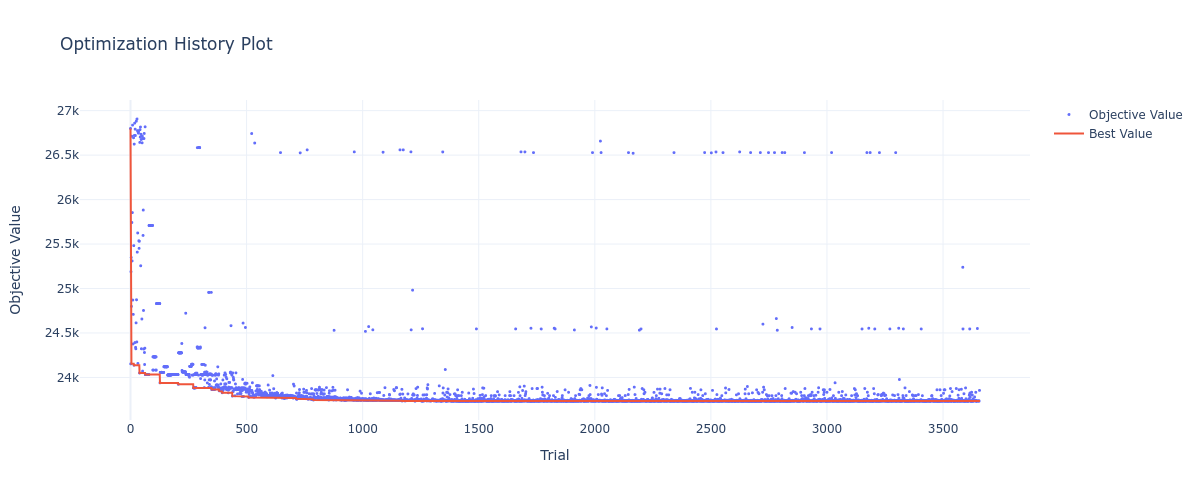

In [21]:
print(f'total trials:                 {len(study_total.trials)}')
print(f'best trial:                   {study_total.best_trial.number}')
print(f'best trial value:             {study_total.best_trial.value}')
print(f'best sequential search value: {linear_model_seq.bic}')

fig = optuna.visualization.plot_optimization_history(study_total).update_traces({'marker': {'size': 3}}).update_layout(width=1200, height=500)
fig.layout.template = 'plotly_white'
fig.show('png')

In [22]:
cols_optuna = [c for c in X.columns if c == 'const' or study_total.best_trial.params[c] == 1]

X_optuna = X[cols_optuna].copy()

lin_mod_opt_res = sm.OLS(y, X_optuna, hasconst=True).fit()
print(lin_mod_opt_res.summary2())

                        Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.771     
Dependent Variable:      TARGET_deathRate     AIC:                    23627.2309
Date:                    2023-12-28 13:01     BIC:                    23735.0674
No. Observations:        2954                 Log-Likelihood:         -11796.   
Df Model:                17                   F-statistic:            585.3     
Df Residuals:            2936                 Prob (F-statistic):     0.00      
R-squared:               0.772                Scale:                  173.20    
--------------------------------------------------------------------------------
                         Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------
const                    224.7699   9.9816  22.5184 0.0000   205.1983   244.3416
medIncome                  0.0004   0.0000   8.9858 0

In [23]:
compute_vifs(X_optuna)

,vif
medIncome,1699.301255
PctPublicCoverageAlone,23.560538
PctMarriedHouseholds,22.051065
PctEmpPrivCoverage,14.844735
PctHS18_24,10.868799
BirthRate,9.912211
PctPublicCoverage,6.983254
AvgHouseholdSize,5.544352
MedianAge,4.954332
PercentMarried,4.441488


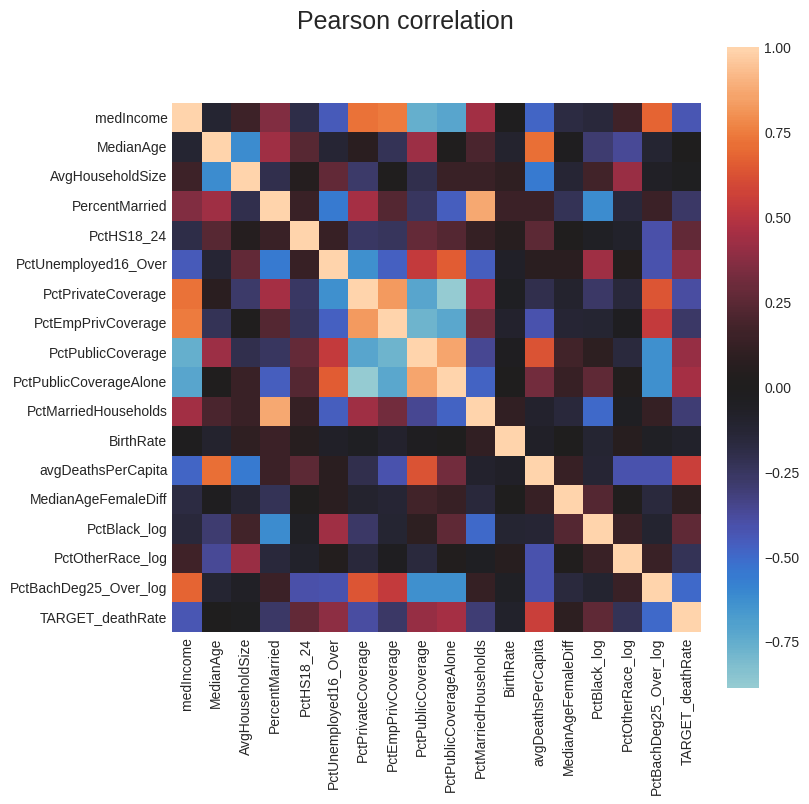

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), layout="constrained")
ax = sns.heatmap(pd.concat([X_optuna.drop(columns=['const']), y], axis=1).corr(method='pearson'), center=0.0, cmap='icefire', cbar=True, square=True)
fig.suptitle('Pearson correlation', fontsize=18)
fig.show()

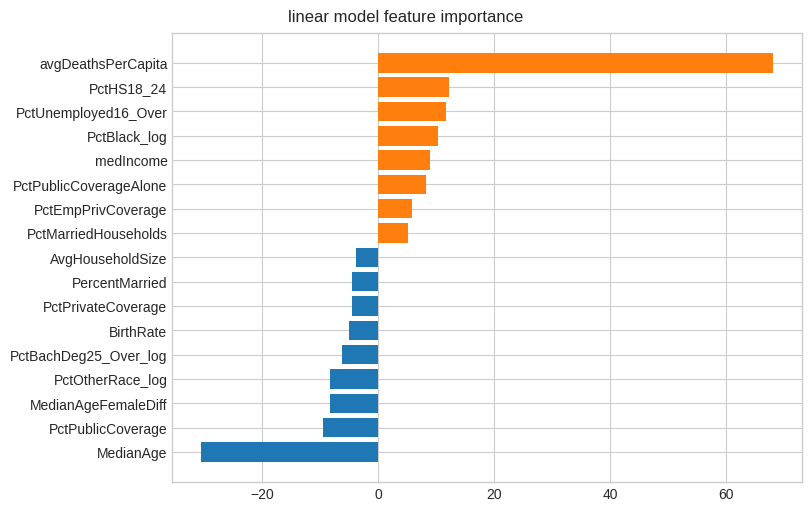

In [25]:
lin_mod_t_values = lin_mod_opt_res.tvalues[lin_mod_opt_res.tvalues.index != 'const']
lin_mod_t_values.sort_values(inplace=True)

bh_color = ['C1' if c > 0 else 'C0' for c in lin_mod_t_values.to_list()]
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
y_pos = np.arange(len(lin_mod_t_values))
ax.barh(
    y_pos,
    lin_mod_t_values,
    color=bh_color,
)
ax.set_yticks(y_pos, labels=lin_mod_t_values.index)
fig.suptitle('linear model feature importance')
fig.show()